In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler

from sklearn.model_selection import  train_test_split , cross_val_score



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

import os
import warnings
warnings.filterwarnings('ignore')

print(os.listdir("../input/"))

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
train = pd.read_csv('../input/train.csv' , index_col = 'PassengerId')
label = train['Survived']

test = pd.read_csv('../input/test.csv', index_col = 'PassengerId')
index = test.index

In [3]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


> <h3>Survived</h3>
Target variable for this dataset is Survived . So let us do some analysis on this field first.

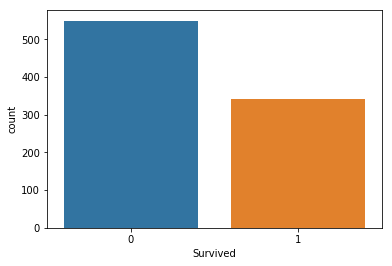

In [5]:
sns.countplot(label)

More than half (around 60%) of the passengers died. 

<h3> Male and Female</h3>

Text(0.5, 1.0, 'Survived passenger under age 21')

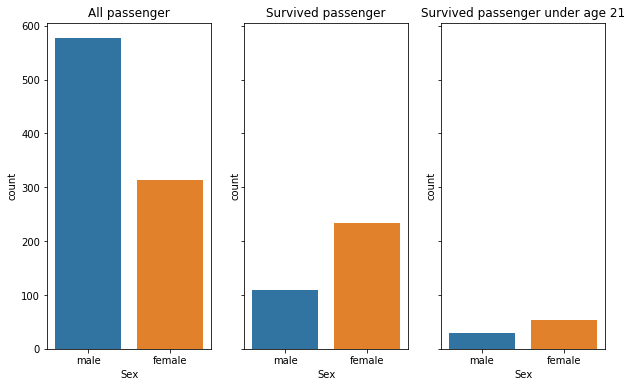

In [6]:
fig, ax =plt.subplots(1,3 , figsize=(10, 6) , sharex='col', sharey='row')
a = sns.countplot(x = 'Sex' , data=train , ax = ax[0] , order=['male' , 'female'])
b = sns.countplot(x = 'Sex' , data= train[label == 1] , ax = ax[1] , order=['male' , 'female'])
c = sns.countplot(x = 'Sex' , data= train[ ((train['Age'] < 21) & (label == 1)) ] , order=['male' , 'female'])
ax[0].set_title('All passenger')
ax[1].set_title('Survived passenger')
ax[2].set_title('Survived passenger under age 21')


1. Majority of passengers were male on Titanic.<br>
2. Most of the female survived.<br>

<h3>Passanger Class</h3>

Text(0.5, 1.0, 'Survived passanger under age 21')

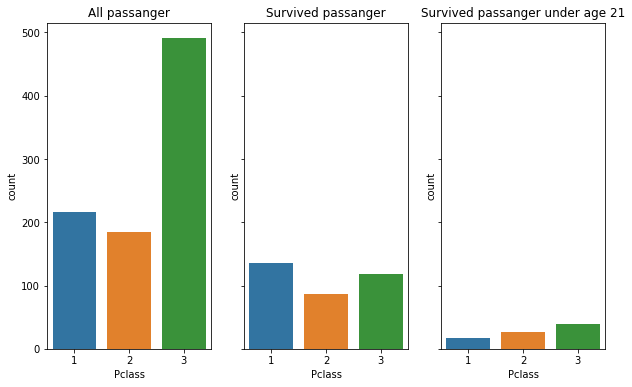

In [7]:
fig, ax =plt.subplots(1,3 , figsize=(10, 6) , sharex='col', sharey='row')
a = sns.countplot(x = 'Pclass' , data=train , ax = ax[0] , order=[1 ,2,3])
b = sns.countplot(x = 'Pclass' , data= train[label == 1] , ax = ax[1] , order=[1 ,2,3])
c = sns.countplot(x = 'Pclass' , data= train[ ((train['Age'] < 21) & (label == 1)) ] , order=[1,2,3])
ax[0].set_title('All passanger')
ax[1].set_title('Survived passanger')
ax[2].set_title('Survived passanger under age 21')


1. Most of the poor people died (ie From passenger class 3) .
2. Most poor people who survived were under age 21

> <h3>Embarked</h3>

Text(0.5, 1.0, 'Survived passanger under age 21')

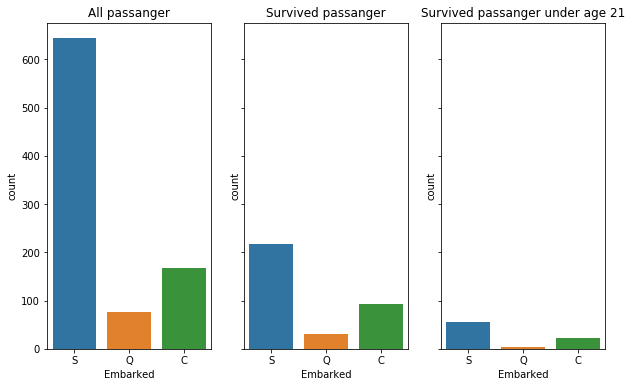

In [8]:
fig, ax =plt.subplots(1,3 , figsize=(10, 6) , sharex='col', sharey='row')
a = sns.countplot(x = 'Embarked' , data=train , ax = ax[0] , order=['S' ,'Q','C'])
b = sns.countplot(x = 'Embarked' , data= train[label == 1] , ax = ax[1] , order=['S' ,'Q','C'])
c = sns.countplot(x = 'Embarked' , data= train[ ((train['Age'] < 21) & (label == 1)) ] , order=['S' ,'Q','C'])
ax[0].set_title('All passanger')
ax[1].set_title('Survived passanger')
ax[2].set_title('Survived passanger under age 21')

1. Most people boarded from Southampton since it the starting port of Titanic.
2. Most of the people who boarded from Southampton died.

<h3> Feature Engineering</h3>

<h4>Deck </h4>
A deck is a permanent covering over a compartment or a hull of a ship. On a boat or ship, the primary or upper deck is the horizontal structure that forms the "roof" of the hull, strengthening it and serving as the primary working surface.<br>
It also gives information in which part of the ship a particular passenger might be when the ship was shinking. 
More information can be found here [here](https://en.wikipedia.org/wiki/RMS_Titanic) in Dimensions and layout section<br>
We can get this information from the first letter of Cabin name if it not NaN

In [9]:
train['Deck'] = train.Cabin.str.get(0)
test['Deck'] = test.Cabin.str.get(0)
train['Deck'] = train['Deck'].fillna('NOTAVL')
test['Deck'] = test['Deck'].fillna('NOTAVL')
#Replacing T deck with closest deck G because there is only one instance of T
train.Deck.replace('T' , 'G' , inplace = True)
train.drop('Cabin' , axis = 1 , inplace =True)
test.drop('Cabin' , axis = 1 , inplace =True)

<h4>Lets count the missing values in train and test</h4>

In [10]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Deck          0
dtype: int64

In [11]:
test.isna().sum()

Pclass       0
Name         0
Sex          0
Age         86
SibSp        0
Parch        0
Ticket       0
Fare         1
Embarked     0
Deck         0
dtype: int64

In training set there is missing value in **Embarked** and **Age**<br>
In training set there is missing value in **Fare** and **Age**

<h4>Let's fill the missing values in Embarked with the most frequent value in train set</h4>

In [12]:
train.loc[train.Embarked.isna() , 'Embarked'] = 'S'

<h4>In the above bar graph we saw that Pclass ,sex , Embarked were the determing factor for the servival of a passenger we will group them using these features and fill the median age in the corresponding missing values in the group</h4>

In [13]:
age_to_fill = train.groupby(['Pclass' , 'Sex' , 'Embarked'])[['Age']].median()
age_to_fill

Age
Pclass Sex    Embarked       
1      female C         37.00
              Q         33.00
              S         34.00
       male   C         36.50
              Q         44.00
              S         42.00
2      female C         22.00
              Q         30.00
              S         29.00
       male   C         29.50
              Q         57.00
              S         30.00
3      female C         14.25
              Q         20.00
              S         23.00
       male   C         26.00
              Q         27.00
              S         25.00

In [14]:
for cl in range(1,4):
    for sex in ['male' , 'female']:
        for E in ['C' , 'Q' , 'S']:
            filll = pd.to_numeric(age_to_fill.xs(cl).xs(sex).xs(E).Age)
            train.loc[(train.Age.isna() & (train.Pclass == cl) & (train.Sex == sex) 
                    &(train.Embarked == E)) , 'Age'] =filll
            test.loc[(test.Age.isna() & (test.Pclass == cl) & (test.Sex == sex) 
                    &(test.Embarked == E)) , 'Age'] =filll

Lets check if the above for loop is correct or not.<br>
There shouldn't be any difference between the previous median of groups and after filling its median in place of NaN

In [15]:
train.groupby(['Pclass' , 'Sex' , 'Embarked'])[['Age']].median()

Age
Pclass Sex    Embarked       
1      female C         37.00
              Q         33.00
              S         34.00
       male   C         36.50
              Q         44.00
              S         42.00
2      female C         22.00
              Q         30.00
              S         29.00
       male   C         29.50
              Q         57.00
              S         30.00
3      female C         14.25
              Q         20.00
              S         23.00
       male   C         26.00
              Q         27.00
              S         25.00

YAY ! There isn't any difference 

Fare is string with number at the end , Two consecutive ticket number means they are bougth from same place or they got same deck on the ship...

In [16]:
train.Ticket = pd.to_numeric(train.Ticket.str.split().str[-1] , errors='coerce')
test.Ticket = pd.to_numeric(test.Ticket.str.split().str[-1] , errors='coerce')

Lets fill the missing Ticket value in train data with median Ticket value and one missing fare value in test data with median fare in train

In [17]:
Ticket_median = train.Ticket.median()
train.Ticket.fillna(Ticket_median , inplace =True)
test.Fare.fillna(train.Fare.median() , inplace =True)

In [18]:
train.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Deck        0
dtype: int64

In [19]:
test.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Deck        0
dtype: int64

Lets create one feature variable **Status** in the society . This features can be derive from the name features like 'Dr' , 'Rev' , 'Col' , 'Major' etc

In [20]:
train['Status'] = train['Name'].str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
test['Status'] = test['Name'].str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
importan_person = ['Dr' , 'Rev' , 'Col' , 'Major' , 'Mlle' , 'Don' , 'Sir' , 'Ms' , 'Capt' , 'Lady' , 'Mme' , 'the Countess' , 'Jonkheer' , 'Dona'] 
for person in importan_person:
    train.Status.replace(person, 'IMP' , inplace =True)
    test.Status.replace(person, 'IMP' , inplace =True)

In [21]:
train.Status.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'IMP'], dtype=object)

In [22]:
test.Status.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'IMP'], dtype=object)

In [23]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Status
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,21171.0,7.2500,S,NOTAVL,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,17599.0,71.2833,C,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,3101282.0,7.9250,S,NOTAVL,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803.0,53.1000,S,C,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450.0,8.0500,S,NOTAVL,Mr


In [24]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Status
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,NOTAVL,Mr
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,NOTAVL,Mrs
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,NOTAVL,Mr
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,NOTAVL,Mr
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,NOTAVL,Mrs


In [25]:
test.drop(['Name' , 'Ticket' ] ,axis = 1, inplace = True)
train.drop(['Survived','Ticket' ,'Name' ], inplace =True , axis =1)

In [26]:
cat_col = ['Pclass' , 'Sex' , 'Embarked' , 'Status' , 'Deck']
train.Pclass.replace({
    1 :'A' , 2:'B' , 3:'C'
} , inplace =True)
test.Pclass.replace({
    1 :'A' , 2:'B' , 3:'C'
} , inplace =True)
train = pd.get_dummies(train , columns=cat_col)
test = pd.get_dummies(test , columns=cat_col)
print(train.shape , test.shape)

(891, 25) (418, 25)


Lets scale the data

In [27]:
scaler = MinMaxScaler()

train= scaler.fit_transform(train)
test = scaler.transform(test)

<h3>Machine Learning</h3>

In [28]:
model = RandomForestClassifier(bootstrap= True , min_samples_leaf= 3, n_estimators = 500 ,
                               min_samples_split = 10, max_features = "sqrt", max_depth= 6)
cross_val_score(model , train , label , cv=5)

array([0.81564246, 0.81005587, 0.8258427 , 0.78651685, 0.85310734])

In [29]:
model = LogisticRegression()
cross_val_score(model , train , label , cv=5)

array([0.82122905, 0.82122905, 0.83146067, 0.80898876, 0.85310734])

In [30]:
from sklearn.svm import SVC
model = SVC(C=4)
cross_val_score(model , train , label , cv=5)

array([0.82122905, 0.82681564, 0.8258427 , 0.78089888, 0.8700565 ])

In [31]:
model.fit(train , label)
pre = model.predict(test)

In [32]:
ans = pd.DataFrame({'PassengerId' : index , 'Survived': pre})
ans.to_csv('submit.csv', index = False)
ans.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


<h3>If you liked this kernel please consider upvoting it.<h3>